<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objectives
- To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
- To understand the importance of a complex loss function.
- To see how we can optimize not only over network parameters, but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [2]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving ferriswheel.jpg to ferriswheel (4).jpg

Upload Style Image


Saving star.jpg to star (2).jpg
Content Path: <_io.BytesIO object at 0x7f69dd40c410>
Style Path: <_io.BytesIO object at 0x7f6969c00ef0>


In [3]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


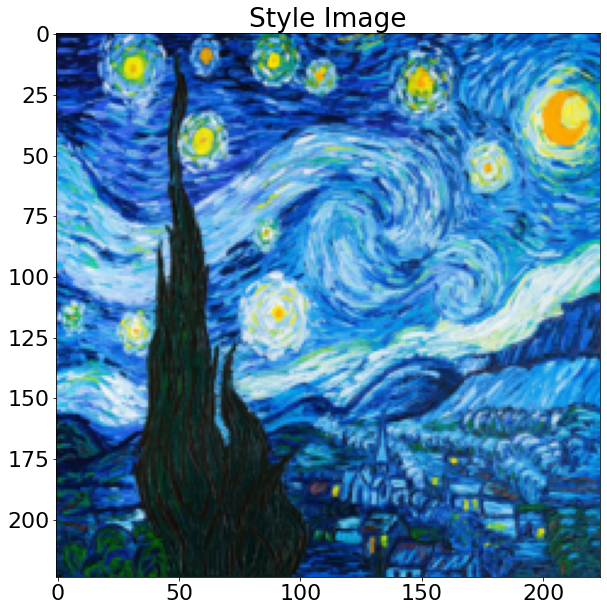

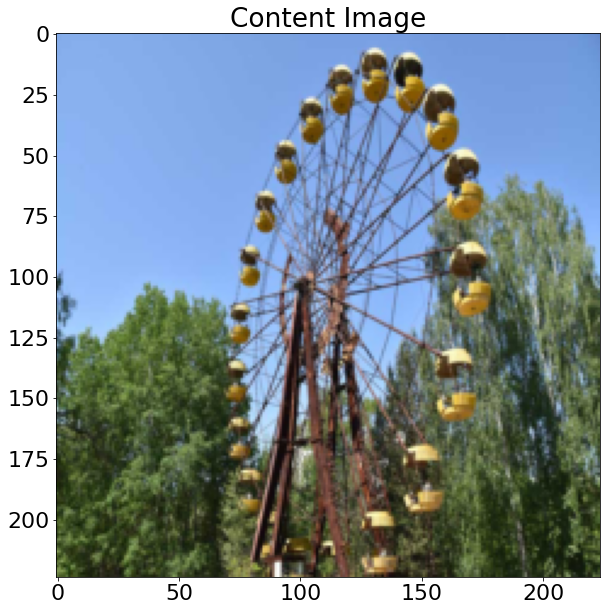

In [4]:
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = (10,10) #make plots big

# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a network instance to extract the layers needed for statistics

**TODO:**

* Correctly initialize a VGGIntermediate object to extract style and content
* Gather content statistics from the outputs of intermediate layers for the content image
* Gather style statistics for the style image

**DONE:**



In [5]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [6]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1",
             "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2",
             "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3",
             "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", 
             "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
layer_choices = ["conv1_1","conv2_1","conv3_1","conv2_1","conv4_1","conv5_1"]
layer_inds = [vgg_names.index(name) for name in layer_choices]

# Create the vgg network in eval mode
#  with our forward method that returns the outputs of the intermediate layers we requested
vgg = VGGIntermediate(requested=layer_inds).cuda()

#pass the images into the vgg's forward function. This returns the vgg's intermediates on the images. I do not know what "intermediates" means in this context, but apparently they are the filters
content_filters = vgg(content_image)
style_filters = vgg(style_image)

# Cache the outputs of the content and style layers for their respective images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 a

___

### Part 2
Create modules for the style and content loss

Note: You may want to try part 4 before implementing the losses to ensure you understand how style transfer loss works.

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the object
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the object

**DONE:**


In [7]:
def gram_matrix(input):
   #input will be 4d tensor
   s1,s2,s3,s4 = input.size()

   #the first two dimensions will give the first feature filter, and the second two the second feature filter... or something like this I cant figure out
      #now we want to actually get those from our input, using view
   features = input.view(s1*s2,s3*s4)

   #now we do standard inner product to get gram matrix; matrix multiplying features with its transpose accomplishes this
   basis = torch.mm(features,features.t())

   return torch.div(basis,s1*s2*s3*s4)

  
class ContentLoss(nn.Module):
  def __init__(self,truth):
    super().__init__()

    #save the truth/target value separate from the rest of the goings-on; detach it so it won't get entangled with other things like gradients as stuff moves through the algorithm
    self.truth = truth.detach()

  def forward(self,input):
    #forward function actually calculates loss; content loss is calculated through mean squared error
    return F.mse_loss(input,self.truth)

#SET OBJECTIVE FOR CONTENT
content_objective = ContentLoss(vgg(content_image)[0])

class StyleLoss(nn.Module):
  def __init__(self,truth):
    super().__init__()

    #once again, detach the truth, but now also get its gram matrix
    self.truth = truth.detach()
    self.gram_truth = gram_matrix(self.truth)

  def forward(self,input):
    #there's this big equation in style loss with 1/4N^2M^2 times a sum; thankfully that N and M are both just sizes of our input
    NM2 = np.prod(input.size())**2
    coeff = 1/(4*NM2)
    
    #in the paper, they choose their weight for the chosen layers to be 1/5 and 0 for the others, so I will do the same
    w = 1/5

    #loss is coeff * w * the mse loss between gram matrices
    return coeff * w * F.mse_loss(self.gram_truth, gram_matrix(input))

#SET OBJECTIVE FOR STYLE
#the layers I'm doing style on are the keys of the vgg on the image aka my layer choice inds

# we'll need to get the vgg's generated image at each of these indices to plug into style loss
style_objectives = [ StyleLoss( vgg(style_image)[layerind]) for layerind in layer_inds ]

def full_style_loss(generated_image):
  """Sums up all the style losses for each of the chosen layers for a full style loss value"""
  loss = 0
  for layerind, obj in zip(layer_inds,style_objectives):
    loss += obj(vgg(generated_image)[layerind])
  return loss

class Total_Loss(nn.Module):
  def __init__(self,cont_truth,style_truth):
    super().__init__()

    self.cont_truth = cont_truth.detach()
    self.style_truth = style_truth.detach()

    self.cont_obj = ContentLoss(cont_truth)
    self.style_obj = StyleLoss(style_truth)

  def forward(self,generated_image):
   alpha, beta = 1, 1e5

   CL = content_objective(vgg(generated_image)[0])
   SL = full_style_loss(generated_image)

   return alpha*CL, beta*SL

def total_loss(generated_image):
  alpha, beta = 1, 1e15

  CL = content_objective(vgg(generated_image)[0])
  SL = full_style_loss(generated_image)

  return alpha*CL, beta*SL

# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison

# Instantiate a style loss module for each style layer 
#  with the style reference image outputs for that layer for comparison


___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1, but feel free to experiment)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!
* Experiment with different hyperparameters or network layers until you're satisfied with your final image

**DONE:**



In [8]:
# Start with a copy of the content image
content_copy = content_image.clone().requires_grad_()

# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors 
optimizer = optim.LBFGS([content_copy],lr=0.1)
objective = ContentLoss(content_image)

num_eps = 50

with tqdm(total=num_eps,position=0) as loop:
  for ep in range(num_eps):
    with torch.no_grad():
     content_copy.clamp_(0.001, 0.999)
    def gogo():
      
      intermediate = vgg(content_copy)

      optimizer.zero_grad()

      CL, SL = total_loss(content_copy)
      loss = CL + SL
      loss.backward()

      loop.set_description("epoch: {}, loss: {:.3f}, style: {:.3f}, content: {:.3f}, min:{:.3f}, max:{:.3f}".format(
          ep, loss.item(), SL.item(), CL.item(), content_copy.min(), content_copy.max()))
      return loss

    optimizer.step(gogo)

#I did it for 500 epochs and it already looked good at 50; also, my original style image did not work well with the algorithm, so I'm just using the classic Starry Night
  
# Show the image

epoch: 49, loss: 0.329, style: 0.167, content: 0.163, min:-0.012, max:1.014:   0%|          | 0/50 [01:48<?, ?it/s]


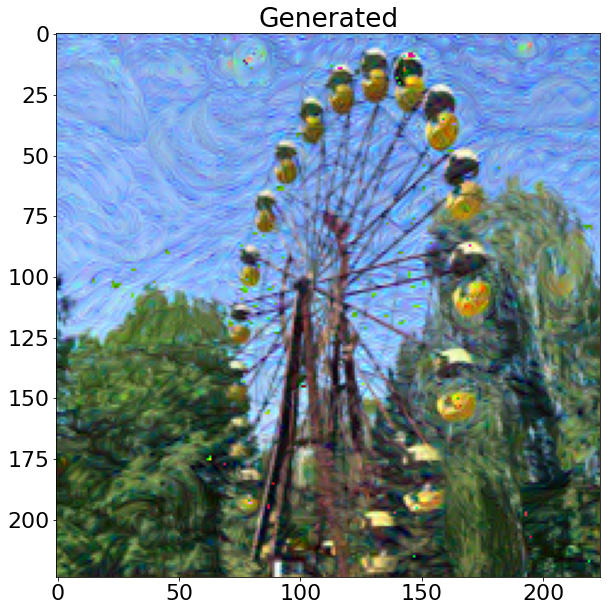

In [9]:
plt.figure()
display(content_copy, title="Generated")
#plt.figure()
#display(content_image, title="Content")
#plt.figure()
#display(style_image, title="Style")

### Part 4

Show that you understand style transfer by describing the key equations of (Gatys 2016) in your own words.

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

**DONE:**
I'm copying this over from a page of notes I wrote and put on the slack.

Equation (1): A feature map is the output of one filter applied to the output of the entire previous layer.
It is a matrix of size (or area) M.
You’ll have an original image p, and its feature maps will get concatenated into a mega
matrix, one for each layer: Pl
. Likewise, the same will be done with our generated image x and its
feature maps: Fl
.
The ij
th component Fl
ij is the activation of the i
th filter at position j in layer l.
Same for Pl
.
Keep in mind that “feature” corresponds to the content of the image like objects, shapes,
lines, etc.
The content loss function is squared-error between the two feature representations.

Equation (3): Style is inferred by DNNs through the correlation between different filter responses. This
correlation is taken over the spatial extent of the input image (i.e. it doesn’t just look at small
blocks of the image at a time but rather the whole thing).
Feature correlations in layer l are given by what’s called the Gram matrix Gl
, where G
l
ij
is the standard inner product (aka the dot product) between the vectorized feature map i and j in
layer l. By “vectorized” we mean that we take a matrix such as Fl
i (which is the activation of the i
th filter
in layer l)and flatten it into a 1d array.

Equation (4): The loss function for style will be mean-squared distance between Gram matrices.
In layer l, let there be Nl number of feature maps, each of size Ml.
Let a be the original image and x be our generated image with layer-respective Gram
matrices Al
and Gl
, respectively ha. The contribution of layer l to the total loss is:

Equation (5): and the total style loss is the sum of these individual contributions from each layer times a
respective weighting factor w.